### MLP in PyTorch

In this exercise, we will implement an MLP based autoencoder to work with the lung data. 

Autoencoders such as the ones we will implement today can be thought to be non-linear PCAs. 

We begin by preparing the data:

1. Load the numpy arrays and labels
2. Create the Torch dataset, dataloaders
3. Reuse the training script from our MLP session
4. Code the MLP!

In [57]:
### Load necessary modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [58]:
# Load the data
data = pd.read_pickle('data.pkl')
# Load labels from the csv file
Y = data.type_num.values ###########
# Convert the labels from 0-1 to -1/+1
# Load the data array
X = data.pdf
X = np.stack(X,axis=0) 


In [60]:
Y_onehot = np.zeros((len(Y),7))
Y_onehot[np.arange(len(Y)),Y-1] = 1

In [67]:
class pdfData(Dataset):
    def __init__(self,data,target,normalize=True):
        super().__init__()
        
        ## Load from numpy
        self.data = torch.FloatTensor(data) ############
        
        ### Add a channel dimension
        self.data = self.data.unsqueeze(1)
        
        ### Normalize intensities to be between 0-1
        if normalize:
            self.data = self.data/self.data.max()
        
        ## Make a tensor target
        self.target = torch.FloatTensor(target)

    def __len__(self):
        ### Method to return number of data points
        return len(self.target)
    
    def __getitem__(self,index):
        ### Method to fetch indexed element
        return self.data[index], self.target[index].type(torch.LongTensor)
        
        

In [85]:
## Make the dataset by passing the numpy arrays!
dataset = pdfData(data=X,target=Y-1)

In [133]:
def multiClassAccuracy(pred,target):
    ### Computes the prediction accuracy based on 
    ### inputs and targets
    
    # Obtain the index of predicted label
#     pdb.set_trace()
    pred = torch.argmax(pred,axis=1)
    acc = 1-((pred != target).sum())/len(target)
    return acc

In [134]:
print(dataset[0][0].shape)
print(data.shape)

torch.Size([1, 3000])
(3743, 4)


In [135]:
#### Make training, validation and test sets
from torch.utils.data import random_split
#### We can use a random split function to make data subsets
train_set, valid_set, test_set = random_split(dataset,[1600,400,1743])
### Wrapping the datasets with DataLoader class opens up 
### batching options
train_loader = DataLoader(train_set,batch_size=4,
                          shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=4,
                         shuffle=True)
test_loader  = DataLoader(test_set,batch_size=4,
                         shuffle=True)

In [136]:
####### Use the content from the MLP notebook 
class MLP(nn.Module):
    def __init__(self,nIp,nhid,nOp):
        super(MLP, self).__init__()
        
        ### Encoder layers 3
        self.enc1 = nn.Linear(nIp,nhid)
        self.enc2 = nn.Linear(nhid,nhid)
        self.enc3 = nn.Linear(nhid,nOp)
        
    def forward(self, x):

        ### Fill in the forward layer
        ### by calling the corresponding layers
        ### initialized above. 
        ### You can use F.relu() to call the
        ### rectified linear unit activation function
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        yHat = (self.enc3(x))

        return yHat.squeeze()

In [137]:
### Instantiate a model now! 
### Pass suitable parameters for our task
nIp = dataset[0][0].shape[1]
model = MLP(nIp=nIp,nhid=32,nOp=7) #############
criterion = nn.CrossEntropyLoss() ############ Loss function to be optimized. 
# nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #### Which optimizer do you want to use?

Ep: 0: Tr.Loss:1.23,Tr.Acc:0.60, Vl.Loss:0.68
Ep: 1: Tr.Loss:0.52,Tr.Acc:0.84, Vl.Loss:0.37
Ep: 2: Tr.Loss:0.33,Tr.Acc:0.90, Vl.Loss:0.26
Ep: 3: Tr.Loss:0.25,Tr.Acc:0.91, Vl.Loss:0.23
Ep: 4: Tr.Loss:0.21,Tr.Acc:0.92, Vl.Loss:0.19
Ep: 5: Tr.Loss:0.17,Tr.Acc:0.94, Vl.Loss:0.17
Ep: 6: Tr.Loss:0.14,Tr.Acc:0.94, Vl.Loss:0.16
Ep: 7: Tr.Loss:0.13,Tr.Acc:0.95, Vl.Loss:0.14
Ep: 8: Tr.Loss:0.12,Tr.Acc:0.95, Vl.Loss:0.14
Ep: 9: Tr.Loss:0.10,Tr.Acc:0.96, Vl.Loss:0.13
Ep: 10: Tr.Loss:0.09,Tr.Acc:0.96, Vl.Loss:0.12
Ep: 11: Tr.Loss:0.09,Tr.Acc:0.96, Vl.Loss:0.12
Ep: 12: Tr.Loss:0.08,Tr.Acc:0.97, Vl.Loss:0.14
Ep: 13: Tr.Loss:0.08,Tr.Acc:0.97, Vl.Loss:0.23
Ep: 14: Tr.Loss:0.08,Tr.Acc:0.96, Vl.Loss:0.13
Ep: 15: Tr.Loss:0.08,Tr.Acc:0.97, Vl.Loss:0.13
Ep: 16: Tr.Loss:0.07,Tr.Acc:0.98, Vl.Loss:0.13
Ep: 17: Tr.Loss:0.06,Tr.Acc:0.97, Vl.Loss:0.17
Ep: 18: Tr.Loss:0.08,Tr.Acc:0.97, Vl.Loss:0.13
Ep: 19: Tr.Loss:0.06,Tr.Acc:0.98, Vl.Loss:0.12
Ep: 20: Tr.Loss:0.06,Tr.Acc:0.97, Vl.Loss:0.14
Ep: 21: Tr.Loss:0.05,Tr

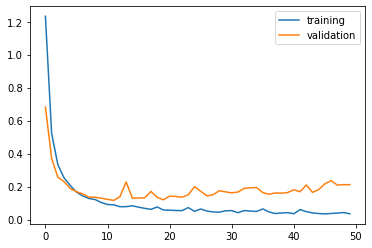

In [138]:
####
import pdb
#### Training and validation loop!

trLoss = []
trAcc = []
vlLoss = []
vlAcc = []
impute = True

for epoch in range(50): ### Run the model for a certain number of iterations/epochs
    
    epLoss = 0
    epAcc = 0
    
    for x, y in train_loader: ### Fetch a batch of training inputs
        
        # Copy input as label
        
        yHat = model(x) ####### Obtain a prediction from the network
#         pdb.set_trace()
        loss = criterion(yHat,y) ######### Compute the loss between prediction and ground truth
        
        ### Backpropagation steps
        ### Clear old gradients
        optimizer.zero_grad()
        ### Compute the gradients wrt model weights
        loss.backward()
        ### Update the model parameters
        optimizer.step()
        
        epLoss += loss.item()
        epAcc += multiClassAccuracy(yHat,y)
    trLoss.append(epLoss/len(train_loader))
    trAcc.append(epAcc/len(train_loader))
    
    epLoss = 0

    
    for x, y in valid_loader: #### Fetch validation samples
        
        yHat = model(x) ##########
        loss = criterion(yHat,y)#######
        
        epLoss += loss.item()
    vlLoss.append(epLoss/len(valid_loader))
    print("Ep: %d: Tr.Loss:%.2f,Tr.Acc:%.2f, Vl.Loss:%.2f"%(epoch,trLoss[-1],
                                                    trAcc[-1],vlLoss[-1]))    
plt.plot(trLoss,label='training')
plt.plot(vlLoss,label='validation')
plt.legend()

In [107]:
yHat = torch.argmax(yHat,axis=1)

In [108]:
len(torch.where(yHat != y))

(tensor([], dtype=torch.int64),)

In [97]:
print(y)

tensor([3, 3, 6, 3])


In [115]:
y

tensor([3, 1, 1, 6])

In [116]:
yHat

tensor([[ -5.6786,  -1.3440, -10.5970,   5.7205,  -0.5066,  -8.5397, -16.2860],
        [-12.3815,   1.5347,  -8.2226,  -0.5939,  -2.9620,  -6.9330, -18.3955],
        [ -8.2841,   0.2820,  -1.7660, -11.2735,  -5.0580,  -2.1836,  -8.4502],
        [ -4.0930,  -9.3534,   1.7752, -23.5068, -12.3765,  -0.4605,   6.5890]],
       grad_fn=<SqueezeBackward0>)

In [122]:
multiClassAccuracy(yHat,y)

> <ipython-input-121-3dce5b5b3e46>(7)multiClassAccuracy()
      5     # Obtain the index of predicted label
      6     pdb.set_trace()
----> 7     pred = torch.argmax(pred,axis=1)
      8     acc = 1-len(torch.where(pred != target))/len(target)
      9     return acc



ipdb>  pred


tensor([[ -5.6786,  -1.3440, -10.5970,   5.7205,  -0.5066,  -8.5397, -16.2860],
        [-12.3815,   1.5347,  -8.2226,  -0.5939,  -2.9620,  -6.9330, -18.3955],
        [ -8.2841,   0.2820,  -1.7660, -11.2735,  -5.0580,  -2.1836,  -8.4502],
        [ -4.0930,  -9.3534,   1.7752, -23.5068, -12.3765,  -0.4605,   6.5890]],
       grad_fn=<SqueezeBackward0>)


ipdb>  n


> <ipython-input-121-3dce5b5b3e46>(8)multiClassAccuracy()
      5     # Obtain the index of predicted label
      6     pdb.set_trace()
      7     pred = torch.argmax(pred,axis=1)
----> 8     acc = 1-len(torch.where(pred != target))/len(target)
      9     return acc



ipdb>  pred


tensor([3, 1, 1, 6])


ipdb>  len(torch.where(pred!=target)


*** SyntaxError: unexpected EOF while parsing


ipdb>  lne(torch.where(pred!=target))


*** NameError: name 'lne' is not defined


ipdb>  len(torch.where(pred!=target))


1


ipdb>  torch.where(pred!=target)


(tensor([], dtype=torch.int64),)


ipdb>  (pred!=target).sum()


tensor(0)


ipdb>  q


BdbQuit: 

In [119]:
torch.argmax(yHat,axis=1)

tensor([3, 1, 1, 6])